In [1]:
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
month = '201707'

towmetds = Dataset('data/cesar_tower_meteo_lc1_t10_v1.0_%s.nc' % month)
meteods = Dataset('data/cesar_surface_meteo_lc1_t10_v1.0_%s.nc' % month)
fluxds = Dataset('data/cesar_surface_flux_lc1_t10_v1.0_%s.nc' % month)

The Obukhov length is computed as follows (Hogstrom 1988):

$$
L=-\frac{u_*^3 T_0}{kg\overline{w'\theta_v}}
$$

where $u_*$ is the friction velocity, $T_0$ the surface temperature, $k$ the von Karman constant (approximately 0.4), $\theta_v$ the flux of potential virtual temperature, $g$ the gravitational constant.

We have

$$
\overline{w'\theta_v}=-\frac{H}{\rho_0 c_p}\left(1+0.07\frac{E\lambda}{H}\right)
$$

With $H$ being the turbulent sensible heat flux and $L\lambda$ the turbulent latent heat flux, $\rho$ the air density, $c_p$ the specific heat. The specific heat is a function of temperature, but between 250 and 350 K it takes values between 1.003 and 1.008 kJ/kg.K, thus we can assume it constant at 1.005.

The air density can be derived using the ideal gas law:

$$
\rho=\frac{P}{RT_0}
$$

with $P$ the surface pressure in Pascal, $T_0$ the surace temperature in Kelvin, and $R$ the specific gas constant. For dry air, $R=287.058$ J/kg.K, and varies slightly depending on the composition of air (e.g. moisture) TODO does it matter?

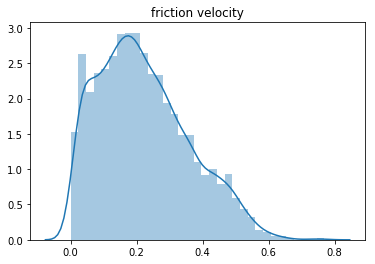

In [3]:
sns.distplot(fluxds['UST'][:])
plt.title('friction velocity')
plt.show()

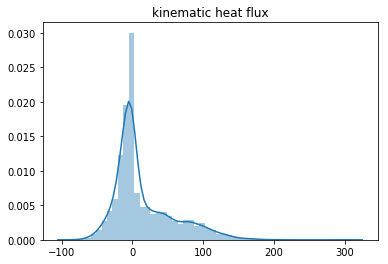

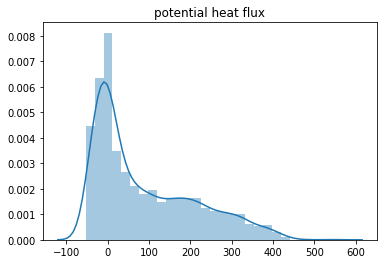

In [4]:
sns.distplot(fluxds['H'][:])
plt.title('kinematic heat flux')
plt.show()

sns.distplot(fluxds['LE'][:])
plt.title('potential heat flux')
plt.show()

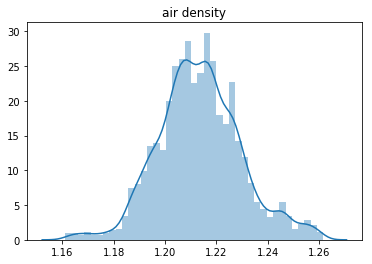

In [5]:
air_density = 100 * meteods['P0'][:] / (287.058 * (273.15 + meteods['TA002'][:]))

sns.distplot(air_density)
plt.title('air density')
plt.show()

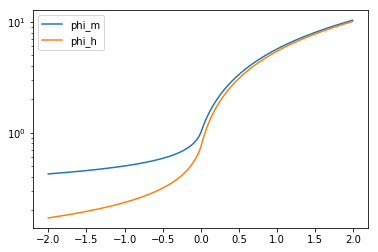

In [6]:
def phi_m(zL):
    if zL < 0:
        return math.pow(1 - 15 * zL, -0.25)
    else:
        return 1 + 4.7 * zL

    
def phi_h(zL):
    if zL < 0:
        return 0.74 * math.pow(1 - 9 * zL, -0.5)
    else:
        return 0.74 + 4.7 * zL


xx = np.arange(-2, 2, 0.01)
ym = list(map(phi_m, xx))
yh = list(map(phi_h, xx))
plt.plot(xx, ym, label='phi_m')
plt.plot(xx, yh, label='phi_h')
plt.yscale('log')
plt.legend()
plt.show()

wind and temperature profile

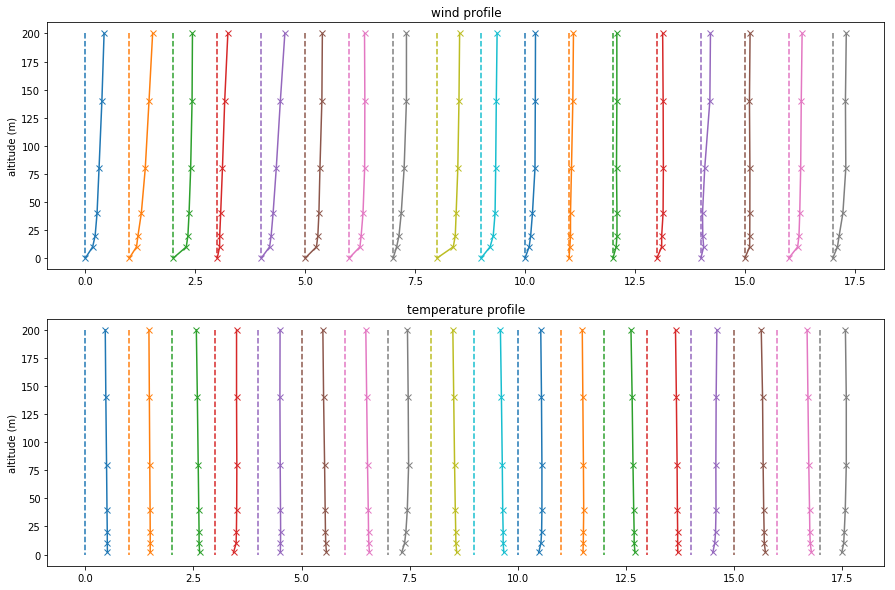

In [7]:
plt.figure(figsize=(15, 5))


fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(15, 10)

ax1.set_title('wind profile')
ax1.set_ylabel('altitude (m)')

ax2.set_title('temperature profile')
ax2.set_ylabel('altitude (m)')

for i, tt in enumerate(towmetds['time'][::250]):
    ws = towmetds['F'][tt][:-1]
    qq = ax1.plot([i + w / 20 for w in ws] + [i], list(towmetds['z'][:-1]) + [0], 'x-')
    ax1.plot([i, i], [200, 0], '--', c=qq[0]._color)
    
    ts = towmetds['TA'][tt]
    qq = ax2.plot([i + (t - 273.15) / 30 for t in ts], towmetds['z'][:], 'x-')
    ax2.plot([i, i], [200, 0], '--', c=qq[0]._color)

plt.show()

wind/temperature profile gradient

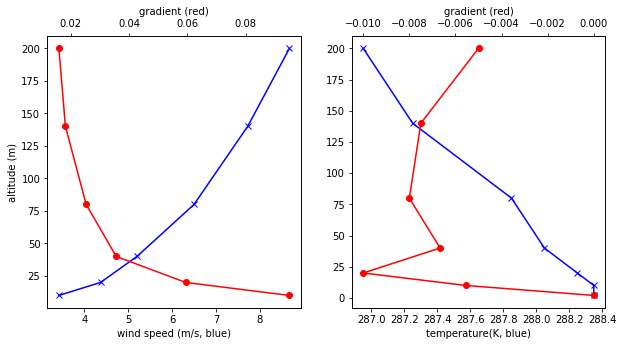

In [8]:
def get_derivative(xs, ys):
    dxdy = []
    for i in range(len(xs)):
        if i == 0:
            d = (ys[i] - ys[i + 1]) / (xs[i] - xs[i + 1])
        elif i == len(xs) - 1:
            d = (ys[i - 1] - ys[i]) / (xs[i - 1] - xs[i])
        else:
            d = (ys[i - 1] - ys[i + 1]) / (xs[i - 1] - xs[i + 1])

        dxdy.append(d)
    
    return dxdy


tt = towmetds['time'][14]

ws = towmetds['F'][tt][:-1]
hw = towmetds['z'][:-1]

ts = towmetds['TA'][tt]
ht = towmetds['z'][:]

dwdz = get_derivative(hw, ws)
dtdz = get_derivative(ht, ts)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

ax1.set_ylabel('altitude (m)')
ax1.plot(ws, hw, 'x-', c='b')
ax1.set_xlabel('wind speed (m/s, blue)')
ax12 = ax1.twiny()
ax12.plot(dwdz, hw, 'o-', c='r')
ax12.set_xlabel('gradient (red)')

ax2.plot(ts, ht, 'x-', c='b')
ax2.set_xlabel('temperature(K, blue)')
ax22 = ax2.twiny()
ax22.plot(dtdz, ht, 'o-', c='r')
ax22.set_xlabel('gradient (red)')

plt.show()

experimental wind shear is computed as

$$
\phi_m\left(\frac{z}{L}\right)=\frac{kz}{u_*}\frac{\partial \overline{U}}{\partial z}
$$

with $\overline{U}$ the average wind speed.

experimental temperature gradient is

$$
\phi_h\left(\frac{z}{L}\right)=
\frac{kz}{\theta_*}\frac{\partial\overline\Theta}{\partial z}=
-\frac{kzu_*c_p\rho}{\overline{w^\prime\Theta_{v_0}^\prime}}\frac{\partial\overline\Theta}{\partial z}
$$

with $\overline{w^\prime\Theta_{v_0}^\prime}$ being the turbulent surface kinematic heat flux and $\theta_*=-\overline{w^\prime\Theta_{v_0}^\prime}/(u_*c_p\rho)$

In [151]:
def process(month):
    try:
        towmetds = Dataset('data/cesar_tower_meteo_lc1_t10_v1.0_%s.nc' % month)
        meteods = Dataset('data/cesar_surface_meteo_lc1_t10_v1.0_%s.nc' % month)
        fluxds = Dataset('data/cesar_surface_flux_lc1_t10_v1.0_%s.nc' % month)
    except:
        import traceback
        print('while loading data for', month)
        traceback.print_exc()
        return

    for i, tt in enumerate(towmetds['time']):
        # use temperature at 0.1m if available, fallback to temperature at 1.5/2m otherwise
        surf_temp = 273.15 + meteods['TA002'][tt]
        air_dens = 100 * meteods['P0'][tt] / (287.058 * surf_temp)

        # following hogstrom 1988, correction accounting for turbulent latent heat flux
        virtual_potential_temperature_flux = -(fluxds['H'][tt] / (1.005 * air_dens)) * (
            1 + 0.07 * fluxds['LE'][tt] / fluxds['H'][tt]
        )

        lval = -fluxds['UST'][tt]**3 * surf_temp / (
            0.4 * 9.81 * virtual_potential_temperature_flux
        )

        assert towmetds['z'][-2] == 10 and towmetds['z'][-1]  == 2

        zL_m = towmetds['z'][-2] / lval
        zL_h = towmetds['z'][-1] / lval

        # compute only at lowest layer (10m)
        # because L and H are computed with surface measurements
        # because of no-slip condition, wind at surface is 0

        dwdz = towmetds['F'][tt, 5] / 10
        phi_m = dwdz * 0.4 * towmetds['z'][-2] / fluxds['UST'][tt]

        dtdz = get_derivative(towmetds['z'][:], towmetds['TA'][tt][:])[-1]
        phi_h = -(
            dtdz * 0.4 * towmetds['z'][-1] * fluxds['UST'][tt] * 1.005 * air_dens
            / fluxds['H'][tt]
        )

        yield {
            'ds': month,
            'year': month[:4],
            'month': month[4:],

            'tt': tt,
            'air_dens': air_dens,

            'H': fluxds['H'][tt],
            'LE': fluxds['LE'][tt],

            'ustar': fluxds['UST'][tt],
            'lval': lval,

            'wind': towmetds['F'][tt, 5],
            'dwdz': dwdz,
            'phi_m': phi_m,
            'zL_m': zL_m,

            'surf_tem': surf_temp,
            'dtdz': dtdz,
            'zL_h': zL_h,
            'phi_h': phi_h,
        }

In [ ]:
dframe_path = 'data/processed.csv.gz'

import os
if os.path.exists(dframe_path):
    print('using saved data')
    df = pd.read_csv(dframe_path, compression='gzip', na_values='--')
else:
    print('recomputing data')
    import findspark
    findspark.init()

    from pyspark import SparkContext
    sc = SparkContext('local[*]')

    all_months = set(f[-6-3:-3] for f in os.listdir('data') if f.endswith('.nc'))

    try:
        df_rows = sc.parallelize(all_months, int(len(all_months) / 2)).flatMap(process).collect()
    finally:
        sc.stop()

    df = pd.DataFrame([row.values() for row in df_rows], columns=df_rows[0].keys())
    df.to_csv('data/processed.csv', index=False, compression='gzip')

In [57]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ds,889632.0,2.009026e+05,4.878089e+02,2.001010e+05,200503.000000,200906.000000,201309.000000,2.017120e+05
year,889632.0,2.008961e+03,4.878095e+00,2.001000e+03,2005.000000,2009.000000,2013.000000,2.017000e+03
month,889632.0,6.515701e+00,3.455705e+00,1.000000e+00,4.000000,7.000000,10.000000,1.200000e+01
tt,889632.0,3.653825e+02,2.112925e+02,0.000000e+00,182.500015,365.166656,547.666687,7.438334e+02
air_dens,889632.0,1.246389e+00,3.270846e-02,1.145826e+00,1.223467,1.243421,1.266678,1.432085e+00
H,889632.0,9.981478e+00,1.225294e+03,-1.552988e+03,-18.382309,-5.645999,4.671073,2.876411e+05
LE,889548.0,4.837842e+01,1.065036e+02,-9.660833e+03,-12.395205,10.347029,70.924194,1.549666e+03
ustar,889632.0,2.443139e-01,1.696264e-01,1.775986e-04,0.123160,0.222855,0.336346,9.370012e+00
lval,889548.0,-7.457470e-02,3.064658e+01,-9.557389e+03,-0.092861,-0.009907,0.016345,3.987525e+03
wind,889632.0,4.227037e+00,2.434961e+00,0.000000e+00,2.430000,3.750000,5.580000,1.922000e+01


TODO what happened in march 2016 to heat measurements?

In [172]:
df[df.ds == 201603].describe().T

,count,mean,std,min,25%,50%,75%,max
ds,4464.0,2.016030e+05,0.000000e+00,2.016030e+05,201603.000000,201603.000000,201603.000000,2.016030e+05
year,4464.0,2.016000e+03,0.000000e+00,2.016000e+03,2016.000000,2016.000000,2016.000000,2.016000e+03
month,4464.0,3.000000e+00,0.000000e+00,3.000000e+00,3.000000,3.000000,3.000000,3.000000e+00
tt,4464.0,3.719167e+02,2.147984e+02,0.000000e+00,185.958332,371.916672,557.874985,7.438333e+02
air_dens,4464.0,1.262615e+00,1.922735e-02,1.236110e+00,1.248944,1.259111,1.272662,1.325392e+00
H,4464.0,1.910508e+03,1.718668e+04,-1.552988e+03,-49.043514,-14.713778,14.623530,2.876411e+05
LE,4380.0,8.997392e+00,5.178742e+02,-9.660833e+03,-32.315110,22.700468,99.187380,1.549666e+03
ustar,4464.0,5.480259e-01,8.786166e-01,1.775986e-04,0.292788,0.406599,0.532916,9.370012e+00
lval,4380.0,-6.097247e-02,1.614064e+00,-1.795089e+01,-0.221918,-0.046635,0.077078,2.394268e+01
wind,4464.0,4.409135e+00,2.840230e+00,1.486356e-01,1.980000,3.760000,6.840000,1.260000e+01


the measurement of $u_*$ is very inaccurate at low values, when there's no turbulence. this causes very small values of L, leading to huge values of |z/L|. hogstrom 1988 uses $u_*>0.1$

In [160]:
pd.plotting.scatter_matrix?

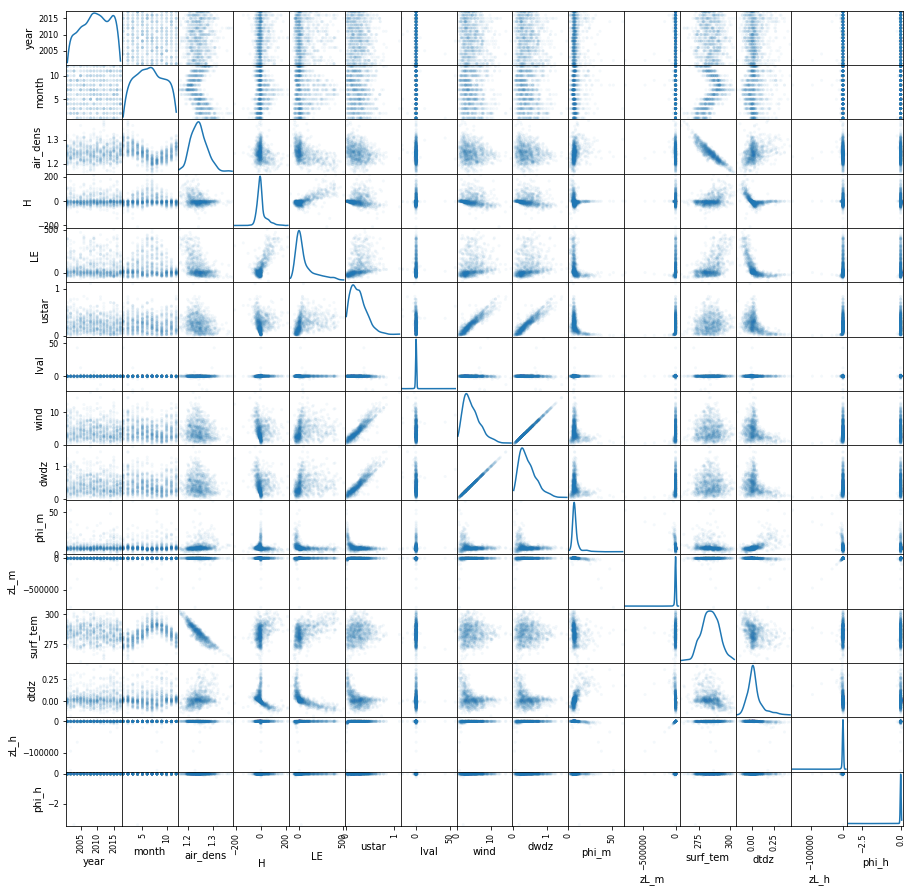

In [162]:
_ = pd.plotting.scatter_matrix(df.sample(1000).drop(['ds', 'tt', ], axis=1),
                               figsize=(15, 15), alpha=0.1, diagonal='kde')

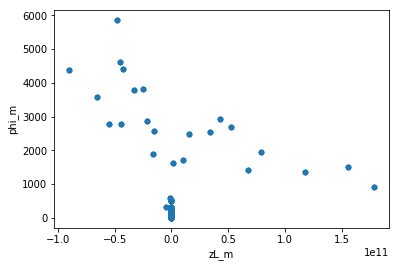

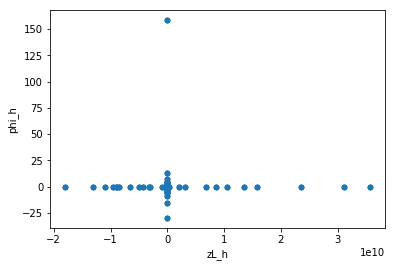

In [70]:
df.plot.scatter('zL_m', 'phi_m')
df.plot.scatter('zL_h', 'phi_h')

hogstrom 1988 only kept measures with $u_*>0.1$ and $\vert H\vert>10$

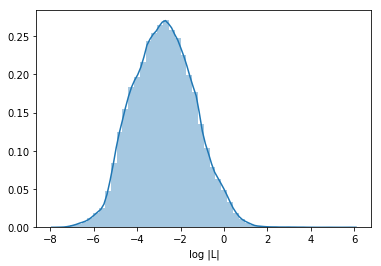

In [152]:
sns.distplot(np.log(df[(df.ustar > 0.1) & (abs(df.H) > 10)].lval.abs().dropna()))
plt.xlabel('log |L|')
plt.show()

clearly this isnt enough for our purposes, and we will filter directly on z/L

In [154]:
good_df = df[(df.zL_m < 5) & (df.zL_m > -5) & (df.zL_h < 5) & (df.zL_h > -5) & (df.ustar > 0.1) & (abs(df.H) > 10)]
print('%.1f%% (%d out of %d) values in a good-ish range' % (
    100 * len(good_df) / len(df), len(good_df), len(df)
))

0.4% (3390 out of 889632) values in a good-ish range


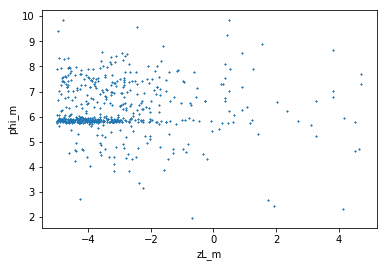

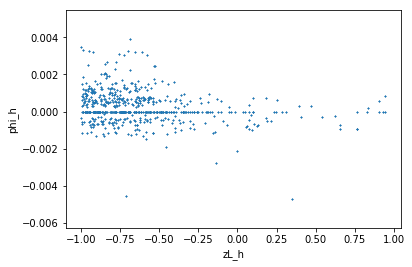

In [156]:
good_df.plot.scatter('zL_m', 'phi_m', s=0.2)
good_df.plot.scatter('zL_h', 'phi_h', s=0.2)